In [1]:
import os
import cv2
from cv2 import sampsonDistance
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.python.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'C:/Users/arvin/OneDrive/Desktop/UNET'

patch_size = 256

Segmentation Models: using `keras` framework.


In [3]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'data':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"\\"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:",path+"\\"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=256)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                


Now patchifying image: C:/Users/arvin/OneDrive/Desktop/UNET\data\MakeRas_20230211_1.jpg


In [4]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"\\"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"\\"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 


Now patchifying mask: C:/Users/arvin/OneDrive/Desktop/UNET\masks\masktest3.png


In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


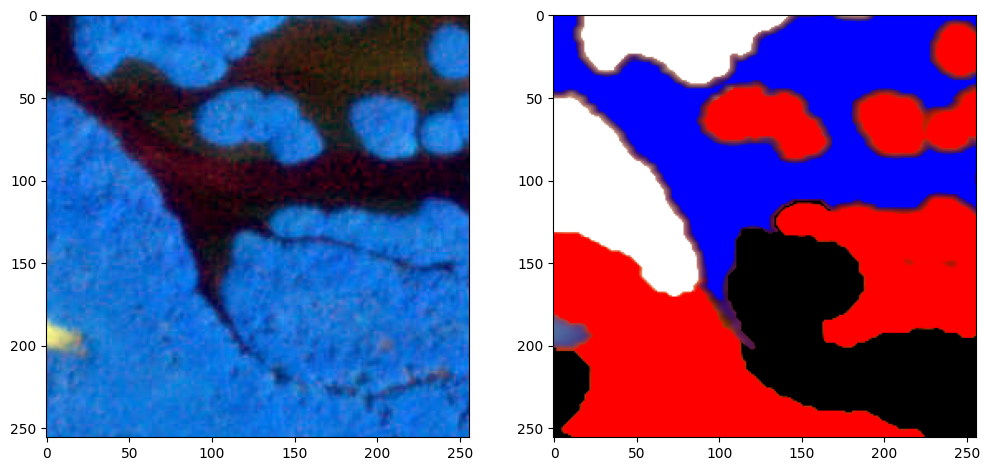

In [8]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


In [9]:
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Black_mangrove = '000000'
Black_mangrove = np.array(tuple(int(Black_mangrove[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Water = '0000FF'
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

White_mangrove = 'FFFFFF' 
White_mangrove = np.array(tuple(int(White_mangrove[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Other =  '00FF00' 
Other = np.array(tuple(int(Other[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Red_mangrove = 'FF0000' 
Red_mangrove = np.array(tuple(int(Red_mangrove[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

label = single_patch_mask


60


In [10]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Black_mangrove,axis=-1)] = 0
    label_seg [np.all(label == Water,axis=-1)] = 1
    label_seg [np.all(label == White_mangrove,axis=-1)] = 2
    label_seg [np.all(label == Other,axis=-1)] = 3
    label_seg [np.all(label == Red_mangrove,axis=-1)] = 4

    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))


Unique labels in label dataset are:  [0 1 2 3 4]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


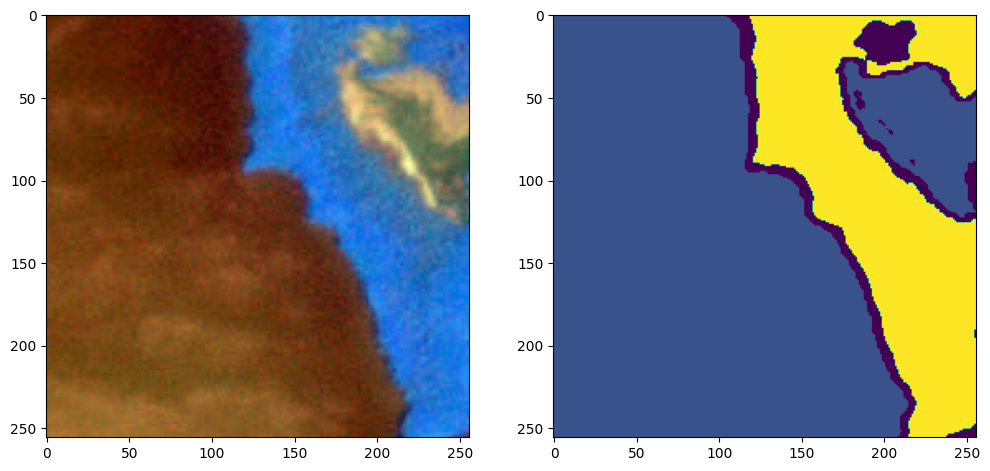

In [14]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [15]:
n_classes = len(np.unique(labels))
from tensorflow.python.keras.utils.np_utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)



In [16]:
from sklearn.utils.class_weight import compute_class_weight

#weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
 #                              np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [19]:
from simple_multi_unet_model import multi_unet_model
from simple_unet_model_with_jacard import jacard_coef 

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=5, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [21]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/100


ValueError: in user code:

    File "c:\Users\arvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\arvin\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\base\objects.py", line 114, in __call__  *
        return self.l1(gt, pr) + self.l2(gt, pr)
    File "c:\Users\arvin\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\losses.py", line 104, in __call__  *
        **self.submodules
    File "c:\Users\arvin\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\base\functional.py", line 150, in f_score  *
        score = average(score, per_image, class_weights, **kwargs)
    File "c:\Users\arvin\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\base\functional.py", line 53, in average  *
        x = x * class_weights

    ValueError: Dimensions must be equal, but are 5 and 6 for '{{node dice_loss_plus_1focal_loss/mul_4}} = Mul[T=DT_FLOAT](dice_loss_plus_1focal_loss/truediv, dice_loss_plus_1focal_loss/mul_4/y)' with input shapes: [5], [6].


In [22]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))


85521592/85521592 [==============================] - 73s 1us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

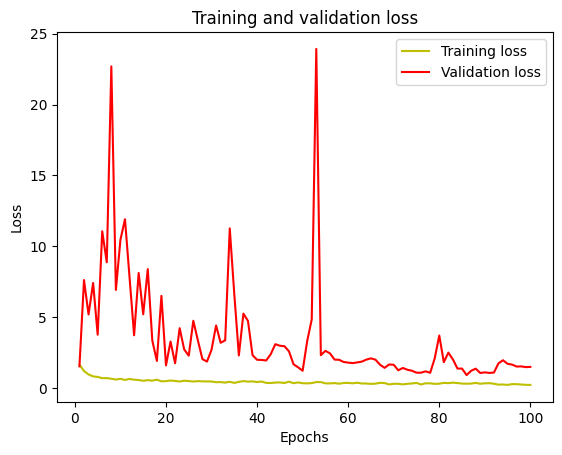

In [23]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


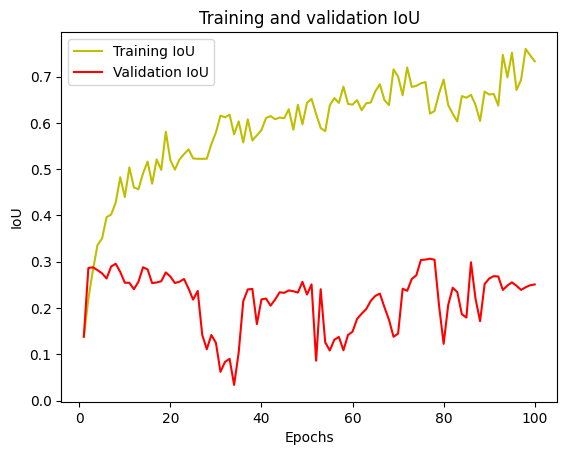

In [24]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [26]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 1s 580ms/step
Mean IoU = 0.0015533584


1/1 [==============================] - 0s 66ms/step


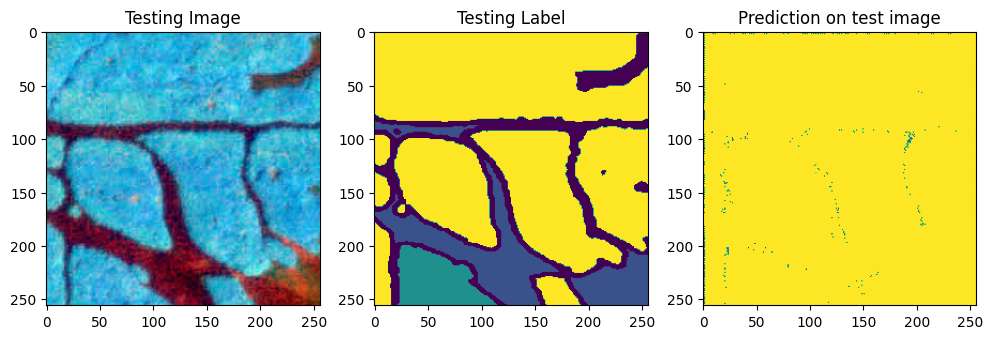

In [30]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()


In [37]:
n_classes = len(np.unique(labels))
from tensorflow.python.keras.utils.np_utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [43]:
from sklearn.utils.class_weight import compute_class_weight

#weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
 #                              np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from simple_multi_unet_model import multi_unet_model
from simple_unet_model_with_jacard import jacard_coef 

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=5, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 256, 256, 16  448         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_99 (Dropout)           (None, 256, 256, 16  0           ['conv2d_209[0][0]']             
                                )                                                          

In [44]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/100
4/4 [==============================] - 14s 3s/step - loss: 1.0413 - accuracy: 0.0210 - jacard_coef: 0.0954 - val_loss: 1.0253 - val_accuracy: 0.0695 - val_jacard_coef: 0.1145
Epoch 2/100
4/4 [==============================] - 10s 2s/step - loss: 1.0218 - accuracy: 0.2079 - jacard_coef: 0.1184 - val_loss: 1.0204 - val_accuracy: 0.2306 - val_jacard_coef: 0.1225
Epoch 3/100
4/4 [==============================] - 10s 2s/step - loss: 1.0164 - accuracy: 0.2826 - jacard_coef: 0.1274 - val_loss: 1.0148 - val_accuracy: 0.3022 - val_jacard_coef: 0.1344
Epoch 4/100
4/4 [==============================] - 10s 2s/step - loss: 1.0117 - accuracy: 0.3243 - jacard_coef: 0.1465 - val_loss: 1.0068 - val_accuracy: 0.4842 - val_jacard_coef: 0.1567
Epoch 5/100
4/4 [==============================] - 10s 2s/step - loss: 1.0081 - accuracy: 0.3539 - jacard_coef: 0.1561 - val_loss: 1.0052 - val_accuracy: 0.4286 - val_jacard_coef: 0.1600
Epoch 6/100
4/4 [==============================] - 10s 2s/step - 

In [45]:
model.save('mangrove.hdf5')


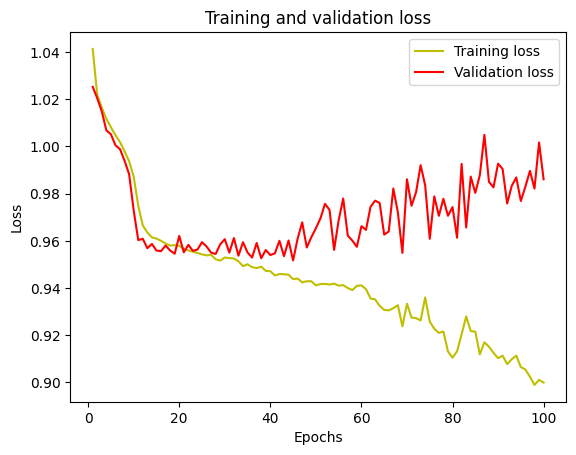

In [46]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


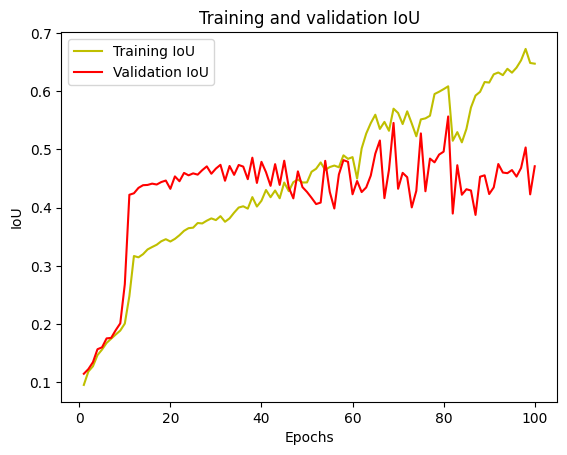

In [47]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [48]:
from patchify import patchify, unpatchify

large_image = cv2.imread('C:/Users/arvin/OneDrive/Desktop/caroni/caroni_export.tif', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()


TypeError: `arr_in` must be a numpy ndarray